In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import glob2 as glob
import missingno as msno
import plotly.express as px
from collections import Counter
import plotly.io as pio


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
relative_path = "data/raw/*.csv" 
file_list = glob.glob(relative_path)

dataframes = []


if not file_list:
    print("No CSV files found in the specified path.")
else:
    # Loop through the file list and read each CSV file into a df
    file_list = sorted(file_list)
    for file in file_list:
        try:
            df = pd.read_csv(file)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

In [4]:
df_event_results = dataframes[1]
df_country = dataframes[4]
df_games = dataframes[5]
df_results = dataframes[3]
df_athletes = dataframes[0]
df_medals = dataframes[2]

In [5]:
dataframes = {'df_athletes': df_athletes, 
       'df_country': df_country, 
       'df_event_results': df_event_results, 
       'df_games': df_games, 
       'df_medals': df_medals, 
       'df_results': df_results}

In [6]:
def count_na(df):
    def helper(val):
        return val == 'na'
    return df.map(helper).sum() / df.shape[0]

In [7]:
for key, value in dataframes.items():
    print(f'\n\n{key}\n\n')
    print(count_na(value))



df_athletes


athlete_id       0.000000
name             0.000000
sex              0.000000
born             0.027633
height           0.326044
weight           0.326044
country          0.000000
country_noc      0.000000
description      0.669215
special_notes    0.610446
dtype: float64


df_country


country_noc    0.0
country        0.0
dtype: float64


df_event_results


edition        0.000000
edition_id     0.000000
country_noc    0.000000
sport          0.000000
event          0.000000
result_id      0.000000
athlete        0.000000
athlete_id     0.000000
pos            0.000000
medal          0.858463
isTeamSport    0.000000
dtype: float64


df_games


edition             0.0
edition_id          0.0
edition_url         0.0
year                0.0
city                0.0
country_flag_url    0.0
country_noc         0.0
start_date          0.0
end_date            0.0
competition_date    0.0
isHeld              0.0
dtype: float64


df_medals


edition        0.0
edition_id     0

In [8]:
# do we have winter olympics available as much? 
dict(Counter([i[5:] for i in df_games['edition'].unique()]))

{'Summer Olympics': 35,
 'Winter Olympics': 27,
 'Equestrian': 1,
 'Intercalated': 1}

In [9]:
# how many athletes take part by country
df_event_results.groupby(['edition', 'country_noc'], as_index=False)['athlete'].count().head()

,edition,country_noc,athlete
0,1896 Summer Olympics,AUS,7
1,1896 Summer Olympics,AUT,10
2,1896 Summer Olympics,BUL,4
3,1896 Summer Olympics,DEN,25
4,1896 Summer Olympics,FRA,51


In [10]:
# one athlete can take part in several events
df_event_results.groupby(['edition', 'country_noc'])['athlete'].unique().reset_index(name='unique_athletes').assign(athlete_count=lambda x: x['unique_athletes'].apply(len)).head()


,edition,country_noc,unique_athletes,athlete_count
0,1896 Summer Olympics,AUS,"[Teddy Flack, George Stuart Robertson]",2
1,1896 Summer Olympics,AUT,"[Adolf Schmal, Otto Herschmann, Paul Neumann]",3
2,1896 Summer Olympics,BUL,[Charles Champaud],1
3,1896 Summer Olympics,DEN,"[Viggo Jensen, Eugen Schmidt, Holger Nielsen, ...",4
4,1896 Summer Olympics,FRA,"[Adolphe Grisel, Jean Tournois, Louis Adler, A...",18


In [11]:
# are the dates reasonable? 
pd.to_datetime(df_games['year'], format='%Y').dt.year.sort_values(ascending=False)

34    2032
33    2028
61    2026
32    2024
60    2022
31    2020
59    2018
30    2016
58    2014
29    2012
57    2010
28    2008
56    2006
27    2004
55    2002
26    2000
54    1998
25    1996
53    1994
52    1992
24    1992
23    1988
51    1988
22    1984
50    1984
49    1980
21    1980
48    1976
20    1976
47    1972
19    1972
18    1968
46    1968
17    1964
45    1964
44    1960
16    1960
62    1956
15    1956
43    1956
14    1952
42    1952
13    1948
41    1948
40    1944
12    1944
39    1940
11    1940
38    1936
10    1936
9     1932
37    1932
8     1928
36    1928
7     1924
35    1924
6     1920
5     1916
4     1912
3     1908
63    1906
2     1904
1     1900
0     1896
Name: year, dtype: int32

In [12]:
# inconsistencies between competition_date and start_date/end_date 
df_games[['start_date', 'end_date', 'competition_date', 'isHeld']]

,start_date,end_date,competition_date,isHeld
0,6 April,15 April,6 – 13 April,NaN
1,NaN,NaN,14 May – 28 October,NaN
2,14 May,NaN,1 July – 26 November,NaN
3,13 July,NaN,27 April – 31 October,NaN
4,6 July,27 July,5 May – 27 July,NaN
5,NaN,NaN,—,Not held due to war
6,14 August,30 August,23 April – 12 September,NaN
7,5 July,27 July,4 May – 27 July,NaN
8,28 July,12 August,17 May – 12 August,NaN
9,30 July,14 August,30 July – 14 August,NaN


<div style="background-color: #f0f0f0; padding: 10px; border-radius: 5px; text-align: center;">
    <h3 style="margin: 0;">Joining</h3>
</div>

In [ ]:
# edition_ids that wont match 

In [46]:
df_medals['edition_id'].nunique()

55

In [47]:
df_games['edition_id'].nunique()

64

In [54]:
# drop war and future events
df_games = df_games.drop(df_games[~df_games['edition_id'].isin(df_medals['edition_id'])].index)

In [55]:
df_games['edition_id'].nunique()

55

In [62]:
df = pd.merge(df_medals, pd.merge(df_games, df_country, on='country_noc', how='left'), on=['edition_id', 'edition', 'year'], how='left',
        suffixes=('_performing', '_host'))


In [64]:
# the special one-time events
len(df[(df['edition_id'] == 4)|(df['edition_id'] == 48)])

25

In [65]:
# drop the one-time events
df = df.drop(df[(df['edition_id'] == 4)|(df['edition_id'] == 48)].index)

In [58]:
count_na(df)

edition                   0.0
edition_id                0.0
year                      0.0
country_performing        0.0
country_noc_performing    0.0
gold                      0.0
silver                    0.0
bronze                    0.0
total                     0.0
edition_url               0.0
city                      0.0
country_flag_url          0.0
country_noc_host          0.0
start_date                0.0
end_date                  0.0
competition_date          0.0
isHeld                    0.0
country_host              0.0
dtype: float64

In [59]:
df.isna().sum()

edition                      0
edition_id                   0
year                         0
country_performing           0
country_noc_performing       0
gold                         0
silver                       0
bronze                       0
total                        0
edition_url                  0
city                         0
country_flag_url             0
country_noc_host             0
start_date                  17
end_date                    39
competition_date             0
isHeld                    1773
country_host                 0
dtype: int64

In [67]:
# the lost data are the one-time events, which we purposely removed
df_medals.shape[0]-df.shape[0]

25

In [71]:
df.describe()

,edition_id,year,gold,silver,bronze,total
count,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000
mean,31.994924,1980.971235,3.706148,3.702200,3.953187,11.361534
std,18.295804,31.675588,7.553642,6.390895,6.138503,19.374113
min,1.000000,1896.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,1960.000000,0.000000,1.000000,1.000000,2.000000
50%,25.000000,1988.000000,1.000000,2.000000,2.000000,5.000000
75%,53.000000,2008.000000,4.000000,4.000000,5.000000,13.000000
max,62.000000,2022.000000,83.000000,85.000000,83.000000,248.000000


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   edition                 1773 non-null   object
 1   edition_id              1773 non-null   int64 
 2   year                    1773 non-null   int64 
 3   country_performing      1773 non-null   object
 4   country_noc_performing  1773 non-null   object
 5   gold                    1773 non-null   int64 
 6   silver                  1773 non-null   int64 
 7   bronze                  1773 non-null   int64 
 8   total                   1773 non-null   int64 
 9   edition_url             1773 non-null   object
 10  city                    1773 non-null   object
 11  country_flag_url        1773 non-null   object
 12  country_noc_host        1773 non-null   object
 13  start_date              1756 non-null   object
 14  end_date                1734 non-null   object
 15  comp

In [77]:
for col in df.select_dtypes(exclude='number'):
    display(df[col].value_counts())

edition
2020 Summer Olympics    93
2008 Summer Olympics    87
2012 Summer Olympics    86
2016 Summer Olympics    86
2000 Summer Olympics    80
1996 Summer Olympics    79
2004 Summer Olympics    74
1992 Summer Olympics    64
1988 Summer Olympics    52
1972 Summer Olympics    48
1984 Summer Olympics    47
1968 Summer Olympics    44
1960 Summer Olympics    44
1952 Summer Olympics    43
1976 Summer Olympics    41
1964 Summer Olympics    41
1948 Summer Olympics    38
1956 Summer Olympics    37
1980 Summer Olympics    36
1928 Summer Olympics    34
1936 Summer Olympics    32
1924 Summer Olympics    31
2018 Winter Olympics    30
2022 Winter Olympics    29
1932 Summer Olympics    28
2014 Winter Olympics    26
2006 Winter Olympics    26
2010 Winter Olympics    26
1998 Winter Olympics    24
2002 Winter Olympics    24
1994 Winter Olympics    22
1920 Summer Olympics    22
1992 Winter Olympics    20
1980 Winter Olympics    19
1912 Summer Olympics    18
1908 Summer Olympics    17
1900 Summer Olympics

country_performing
United States                            50
Finland                                  50
Sweden                                   50
Austria                                  49
Switzerland                              49
Canada                                   49
France                                   49
Norway                                   48
Italy                                    47
Great Britain                            46
Netherlands                              43
Japan                                    36
Germany                                  36
Australia                                34
Belgium                                  33
Hungary                                  33
Poland                                   31
Denmark                                  29
Czechoslovakia                           27
Republic of Korea                        26
New Zealand                              25
Spain                                    24
Romania      

country_noc_performing
USA    50
FIN    50
SWE    50
AUT    49
SUI    49
CAN    49
FRA    49
NOR    48
ITA    47
GBR    46
NED    43
JPN    36
GER    36
AUS    34
BEL    33
HUN    33
POL    31
DEN    29
TCH    27
KOR    26
NZL    25
ESP    24
ROU    21
GRE    21
MEX    21
BUL    21
ARG    20
BRA    20
RSA    19
IND    19
CHN    19
URS    18
TUR    18
IRI    17
JAM    16
POR    16
YUG    16
IRL    16
BLR    15
CUB    15
EST    15
LAT    14
CZE    14
RUS    14
SLO    14
UKR    13
KEN    13
ETH    13
CRO    12
KAZ    12
SVK    12
MGL    12
PRK    12
VEN    11
FRG    11
GDR    11
TPE    11
THA    11
MAR    11
COL    10
EGY    10
TTO    10
BAH    10
NGR    10
PHI     9
PAK     9
INA     9
TUN     8
PUR     8
URU     8
UZB     8
LTU     8
ALG     7
CHI     7
AZE     7
GEO     7
ISR     7
CMR     6
DOM     6
UGA     6
ARM     6
MAS     6
LUX     5
QAT     5
GHA     5
LIE     5
VIE     4
SGP     4
MIX     4
HKG     4
MDA     4
ISL     4
SYR     4
PER     4
SRB     4
KGZ     3
KUW     3
ZIM    

edition_url
/editions/61    93
/editions/53    87
/editions/54    86
/editions/59    86
/editions/25    80
/editions/24    79
/editions/26    74
/editions/23    64
/editions/22    52
/editions/18    48
/editions/21    47
/editions/17    44
/editions/15    44
/editions/13    43
/editions/19    41
/editions/16    41
/editions/12    38
/editions/14    37
/editions/20    36
/editions/9     34
/editions/11    32
/editions/8     31
/editions/60    30
/editions/62    29
/editions/10    28
/editions/58    26
/editions/49    26
/editions/57    26
/editions/46    24
/editions/47    24
/editions/45    22
/editions/7     22
/editions/44    20
/editions/41    19
/editions/6     18
/editions/5     17
/editions/2     17
/editions/43    17
/editions/42    17
/editions/39    17
/editions/40    16
/editions/38    15
/editions/37    14
/editions/36    14
/editions/35    13
/editions/34    13
/editions/33    13
/editions/30    12
/editions/32    11
/editions/29    11
/editions/31    10
/editions/1     10


city
London                    141
Tokyo                     134
Beijing                   116
Rio de Janeiro             86
Athina                     84
Sydney                     80
Atlanta                    79
Los Angeles                75
Barcelona                  64
Seoul                      52
München                    48
Paris                      48
Roma                       44
Ciudad de México           44
Helsinki                   43
Montréal                   41
Melbourne                  37
Moskva                     36
Amsterdam                  34
Berlin                     32
PyeongChang                30
Innsbruck                  30
Lake Placid                29
Vancouver                  26
Torino                     26
Sochi                      26
Sankt Moritz               25
Nagano                     24
Salt Lake City             24
Lillehammer                22
Antwerpen                  22
Albertville                20
Stockholm                  18
Sappo

country_flag_url
/images/flags/USA.png    226
/images/flags/JPN.png    175
/images/flags/GBR.png    141
/images/flags/AUS.png    117
/images/flags/CHN.png    116
/images/flags/FRA.png     94
/images/flags/BRA.png     86
/images/flags/GRE.png     84
/images/flags/CAN.png     84
/images/flags/ITA.png     83
/images/flags/KOR.png     82
/images/flags/ESP.png     64
/images/flags/FRG.png     48
/images/flags/MEX.png     44
/images/flags/FIN.png     43
/images/flags/GER.png     43
/images/flags/URS.png     36
/images/flags/NOR.png     35
/images/flags/NED.png     34
/images/flags/AUT.png     30
/images/flags/RUS.png     26
/images/flags/SUI.png     25
/images/flags/BEL.png     22
/images/flags/SWE.png     18
/images/flags/YUG.png     17
Name: count, dtype: int64

country_noc_host
USA    226
JPN    175
GBR    141
AUS    117
CHN    116
FRA     94
BRA     86
GRE     84
CAN     84
ITA     83
KOR     82
ESP     64
FRG     48
MEX     44
FIN     43
GER     43
URS     36
NOR     35
NED     34
AUT     30
RUS     26
SUI     25
BEL     22
SWE     18
YUG     17
Name: count, dtype: int64

start_date
19 July         158
23 July 2021     93
 8 August        87
 5 August        86
27 July          86
28 July          81
15 September     80
13 August        74
25 July          64
 8 February      61
 4 February      55
17 September     52
 7 February      50
26 August        48
12 February      48
12 October       44
25 August        44
10 October       41
17 July          41
29 July          38
22 November      37
13 February      36
 1 August        32
 5 July          31
 9 February      30
30 July          28
 6 February      26
10 February      26
14 August        22
 6 July          18
 3 February      17
13 July          17
18 February      14
29 January       14
30 January       13
15 February      13
26 January       13
11 February      12
24 January       11
 6 April         10
14 May            5
Name: count, dtype: int64

end_date
12 August         167
 8 August 2021     93
11 September       92
24 August          87
21 August          86
 1 October         80
 3 August          79
 4 August          79
29 August          74
14 August          66
 9 August          64
28 February        57
 2 October         52
27 July            49
23 February        46
27 October         44
25 February        43
24 February        43
24 October         41
 1 August          41
 8 December        37
16 August          32
20 February        29
13 February        27
26 February        26
 5 February        24
22 February        24
30 August          22
27 February        22
19 February        17
15 February        16
18 February        15
 9 February        14
 8 February        13
17 February        12
16 February        11
15 April           10
Name: count, dtype: int64

competition_date
21 July –  8 August 2021     93
6 – 24 August                87
25 July – 12 August          86
3 – 21 August                86
13 September –  1 October    80
20 July –  4 August          79
11 – 29 August               74
24 July –  9 August          64
17 September –  2 October    52
26 August – 11 September     48
 6 July – 12 August          47
12 – 27 October              44
25 August – 11 September     44
14 July –  3 August          43
18 July –  1 August          41
11 – 24 October              41
26 July – 14 August          38
22 November –  8 December    37
20 July –  3 August          36
17 May – 12 August           34
1 – 16 August                32
 4 May – 27 July             31
8 – 25 February              30
2 – 20 February              29
30 July – 14 August          28
6 – 23 February              26
11 – 26 February             26
12 – 28 February             26
7 – 22 February              24
9 – 24 February              24
12 – 27 February       

Series([], Name: count, dtype: int64)

country_host
United States                 226
Japan                         175
Great Britain                 141
Australia                     117
People's Republic of China    116
France                         94
Brazil                         86
Greece                         84
Canada                         84
Italy                          83
Republic of Korea              82
Spain                          64
West Germany                   48
Mexico                         44
Finland                        43
Germany                        43
Soviet Union                   36
Norway                         35
Netherlands                    34
Austria                        30
Russian Federation             26
Switzerland                    25
Belgium                        22
Sweden                         18
Yugoslavia                     17
Name: count, dtype: int64

In [82]:
# only df_results hasn't been used yet
df_athletes_events = df_event_results.merge(df_athletes, on='athlete_id', how='left')

In [83]:
df_athletes_events.describe()

,edition_id,result_id,athlete_id
count,314907.000000,3.149070e+05,3.149070e+05
mean,30.164277,1.502015e+06,1.237813e+05
std,18.384669,4.783510e+06,2.524551e+05
min,1.000000,1.000000e+00,1.000000e+00
25%,16.000000,3.150500e+04,3.602050e+04
50%,24.000000,6.581000e+04,7.633300e+04
75%,49.000000,2.600000e+05,1.110280e+05
max,62.000000,9.001677e+07,2.200000e+07


In [85]:
for col in df_athletes_events.select_dtypes(exclude='number'):
    display(df_athletes_events[col].value_counts().head(10))

edition
2020 Summer Olympics    14786
2000 Summer Olympics    14032
1996 Summer Olympics    13994
2008 Summer Olympics    13975
2016 Summer Olympics    13941
2004 Summer Olympics    13756
1992 Summer Olympics    13485
2012 Summer Olympics    13196
1988 Summer Olympics    12780
1972 Summer Olympics    10903
Name: count, dtype: int64

country_noc_x
USA    23551
FRA    15337
GBR    13715
ITA    12395
CAN    11717
GER    11506
JPN    10170
SWE     9438
AUS     8847
HUN     7540
Name: count, dtype: int64

sport
Athletics               47481
Artistic Gymnastics     27580
Swimming                26246
Fencing                 11957
Shooting                11709
Rowing                  11321
Cross Country Skiing    11096
Alpine Skiing           10486
Football                 9384
Wrestling                7409
Name: count, dtype: int64

event
Football, Men                 7834
Ice Hockey, Men               5544
Hockey, Men                   4574
Individual, Men               4032
Basketball, Men               3577
Water Polo, Men               3487
Singles, Men                  3197
Road Race, Individual, Men    3068
4 × 100 metres Relay, Men     2786
Singles, Women                2720
Name: count, dtype: int64

athlete
Tait McKenzie          58
Heikki Savolainen      39
Josy Stoffel           38
Ioannis Theofilakis    33
Takashi Ono            33
Andreas Wecker         32
Jean Jacoby            32
Al Jochim              31
Alfred Munnings        31
Hans Sauter            31
Name: count, dtype: int64

pos
1      16043
2      15567
3      14217
4      13370
5      11810
6      11323
7      10266
8       9804
DNS     8330
DNF     8095
Name: count, dtype: int64

medal
na        270336
Gold       15027
Bronze     14904
Silver     14640
Name: count, dtype: int64

isTeamSport
False    194095
True     120812
Name: count, dtype: int64

name
Tait McKenzie          58
Heikki Savolainen      39
Josy Stoffel           38
Takashi Ono            33
Ioannis Theofilakis    33
Andreas Wecker         32
Jean Jacoby            32
Michel Mathiot         31
Alfred Munnings        31
Hans Sauter            31
Name: count, dtype: int64

sex
Male      225597
Female     89310
Name: count, dtype: int64

born
na            5755
1931-01-01     129
1903-01-01     117
1902-01-01     117
1897-01-01     110
1900-01-01      94
1901-01-01      92
1898-01-01      90
1932-01-01      90
1880-01-01      85
Name: count, dtype: int64

height
na       86866
180.0    13568
170.0    12776
178.0    11531
175.0    11161
183.0     8953
168.0     8824
172.0     8457
173.0     8383
165.0     7833
Name: count, dtype: int64

weight
na    86866
70    10610
60     8730
75     8484
68     7987
65     7959
72     6903
80     6800
73     6532
63     6446
Name: count, dtype: int64

country
 United States    23403
 France           15236
 Great Britain    13680
 Italy            12344
 Canada           11660
 Germany          10452
 Japan            10162
 Sweden            9418
 Australia         8724
 Hungary           7465
Name: count, dtype: int64

country_noc_y
USA    23407
FRA    15348
GBR    13756
ITA    12398
CAN    11793
GER    11650
JPN    10180
SWE     9426
AUS     8894
HUN     7541
Name: count, dtype: int64

description
na                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

special_notes
na                                                                                                               163105
Listed in Olympians Who Received the Italian Olympic Association (CONI) Gold Medal ()                               635
Listed in Olympians Who Contracted the Coronavirus (COVID-19) ()                                                    328
Listed in Olympians Who Reached the Age of 100 ()                                                                   128
Listed in Olympians Who Died in Motor Vehicle Accidents (Boat/Car/Motorcycle/Train) (Died in a car accident.)       107
Listed in Olympian Members of the Nobility (Count)                                                                   85
Listed in Olympians Who Contracted the Coronavirus (COVID-19) (Died from the effects of the coronavirus.)            81
Listed in Olympians Who Participated in the 2012 Olympic Football Qualification Campaign (men) ()                    69
Listed in Olympians Who Co

In [124]:
def eda_visualization(df):
    numerical_columns = df.select_dtypes(include='number').columns
    categorical_columns = df.select_dtypes(exclude='number').columns

    for column in numerical_columns:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        
        plt.subplot(1, 2, 2)
        ax = sns.boxplot(data=df, x=column, showfliers=False)
        plt.title(f'Boxplot of {column} Without Outliers')
        
        def add_quartile_labels(ax):
            for line in ax.lines:
                x, y = line.get_xydata()[0]  
                ax.text(x, y, f"{x:.0f}", ha='left', va='center')
        
        add_quartile_labels(ax)

        plt.tight_layout()
        plt.show()

    for column in categorical_columns:
        plt.figure(figsize=(10, 4))
        categories_to_show = df[column].value_counts().index[:30]
        sns.countplot(data=df[df[column].isin(categories_to_show)], x=column, order=categories_to_show)
        
        for idx, count in enumerate(df[df[column].isin(categories_to_show)][column].value_counts()):
            plt.text(idx, count + 1, str(count), ha='center', va='bottom', fontsize=8)
        

        plt.title(f'Count of each category in {column}')
        plt.xticks(rotation=90, ha='right', fontsize=7)
        plt.tight_layout()
        plt.show()

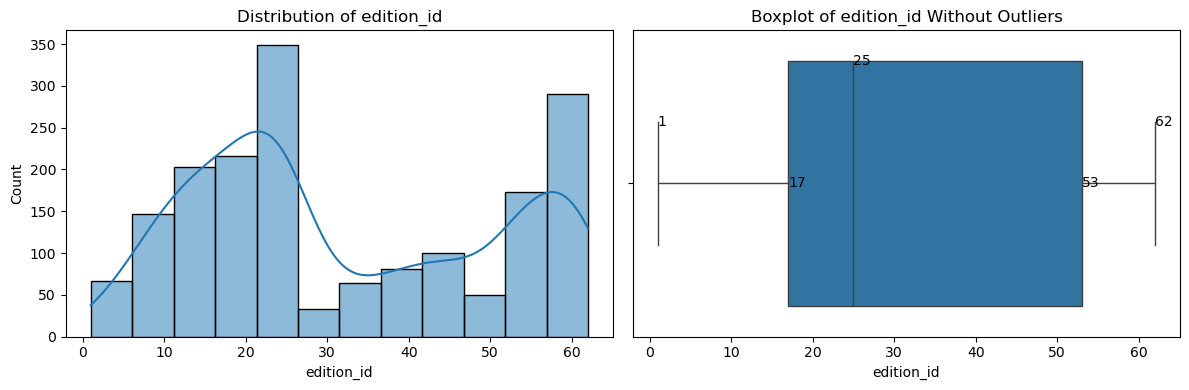

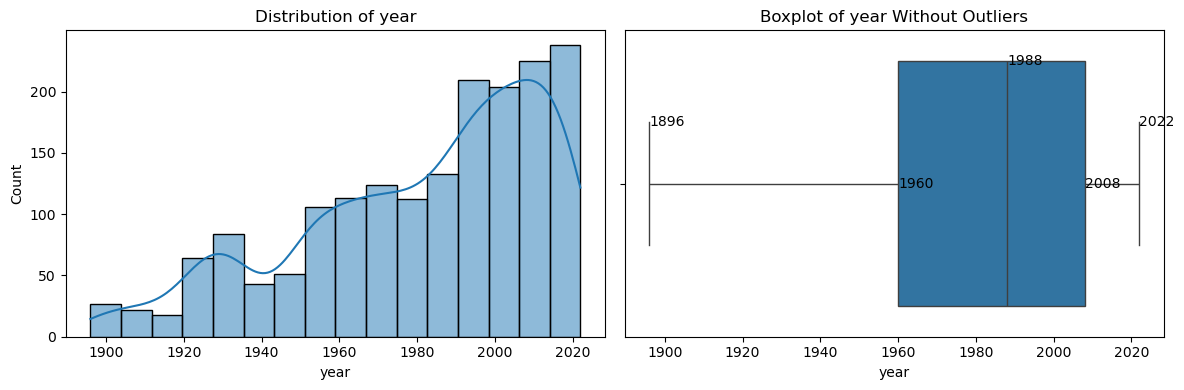

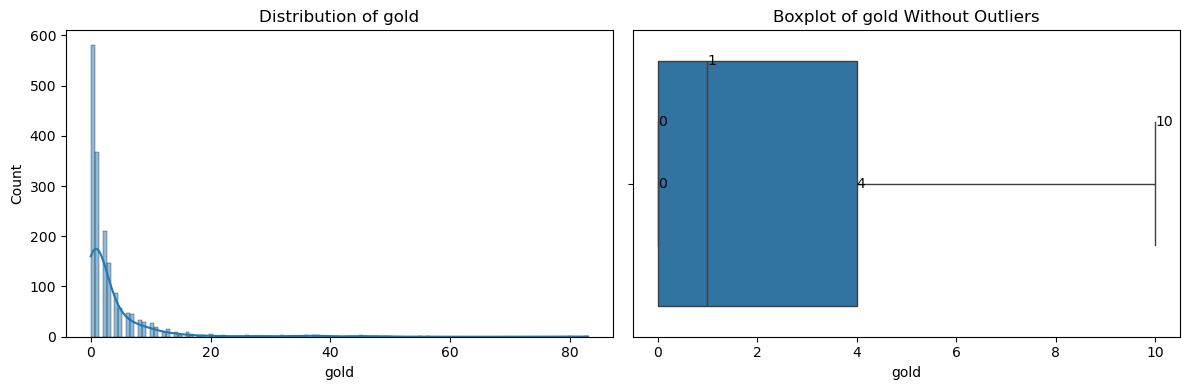

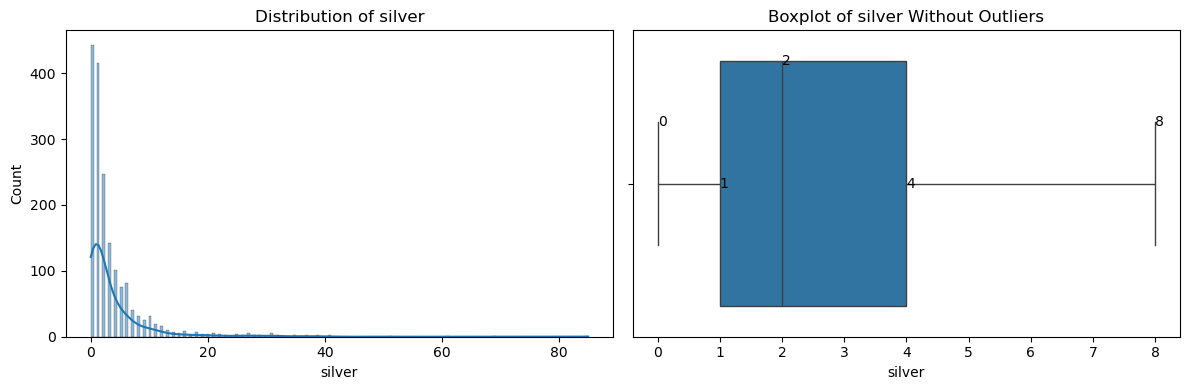

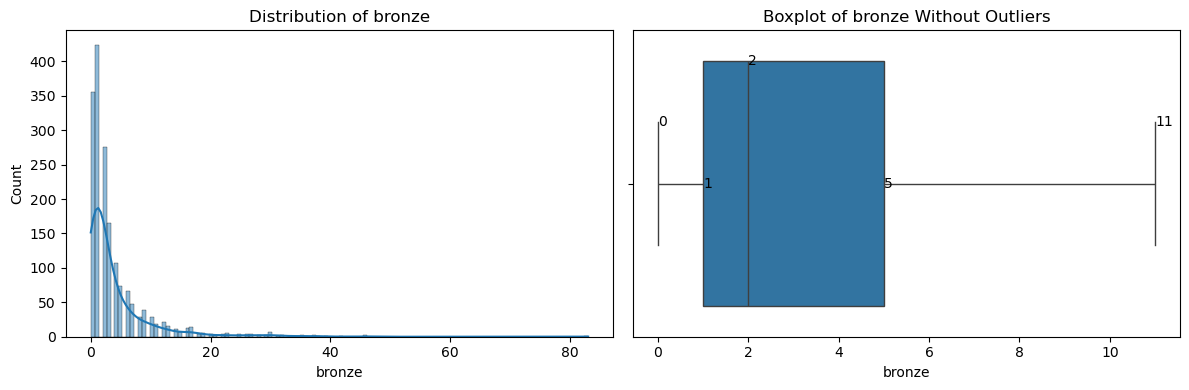

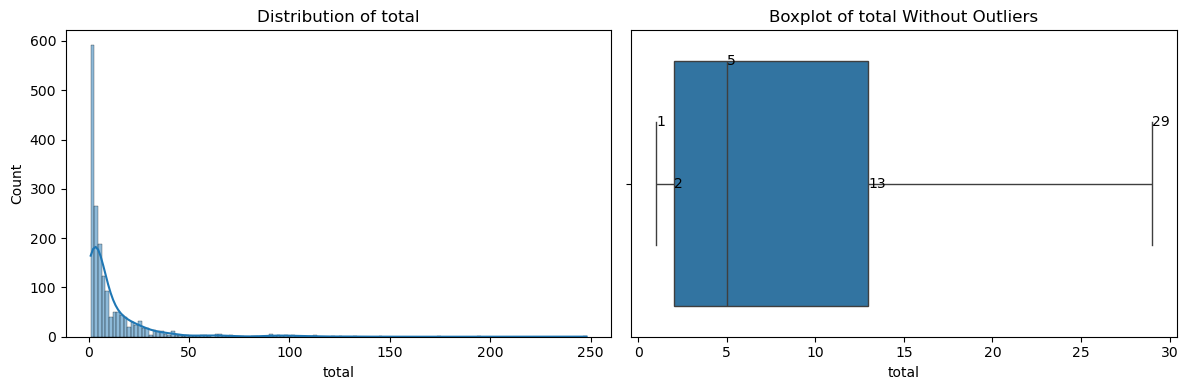

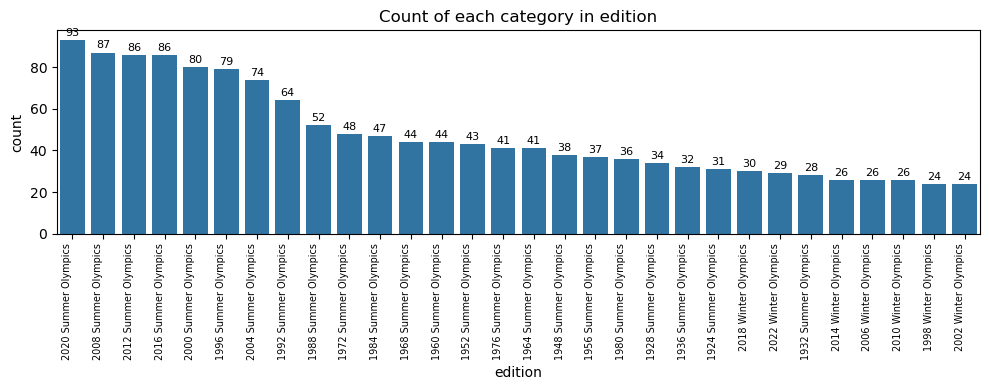

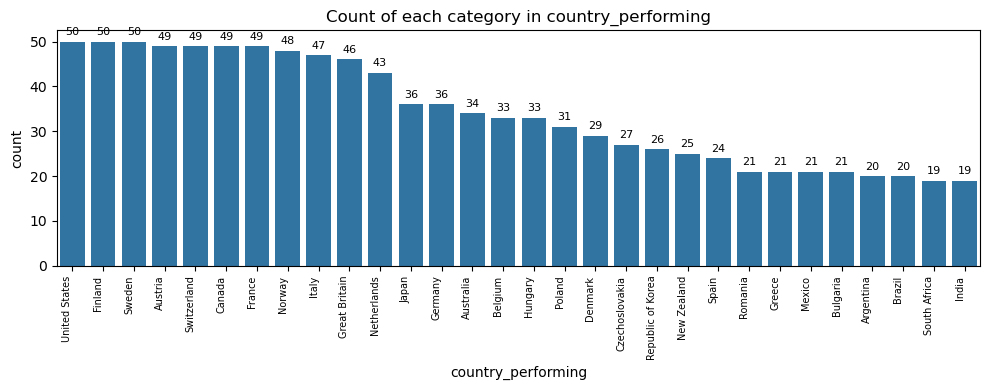

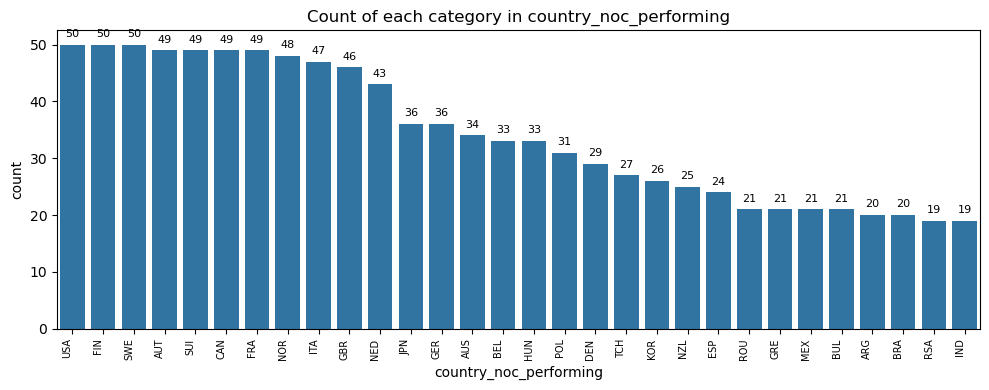

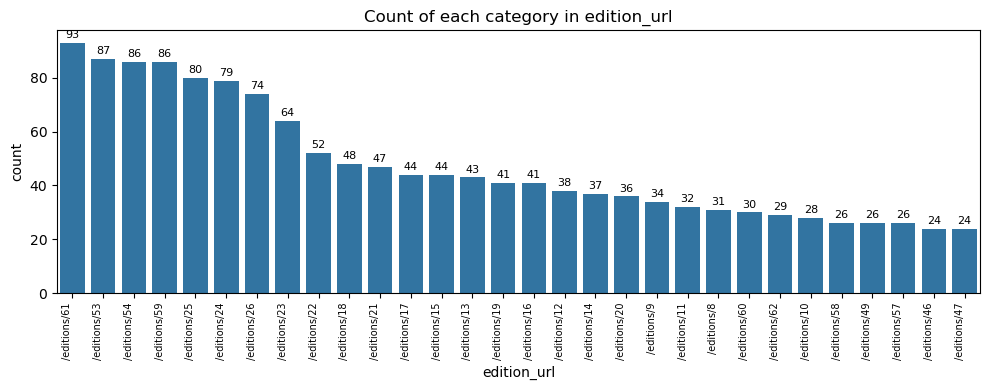

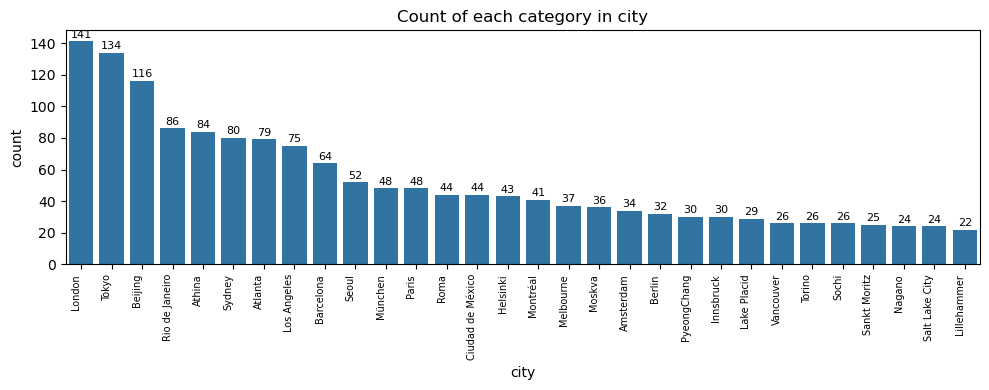

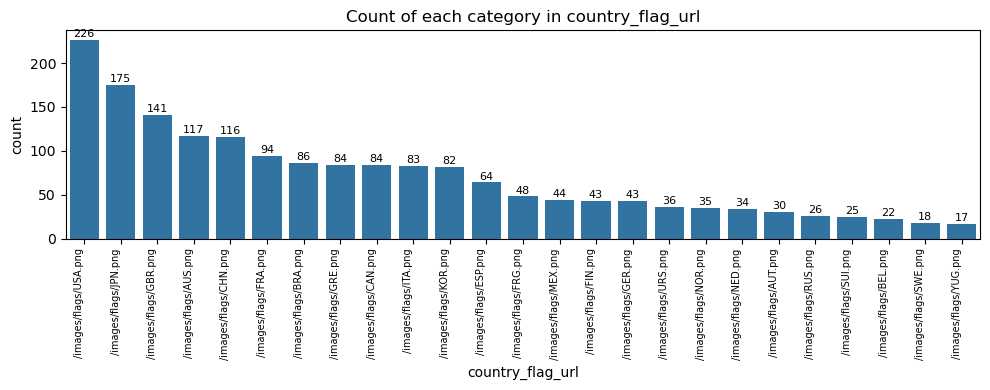

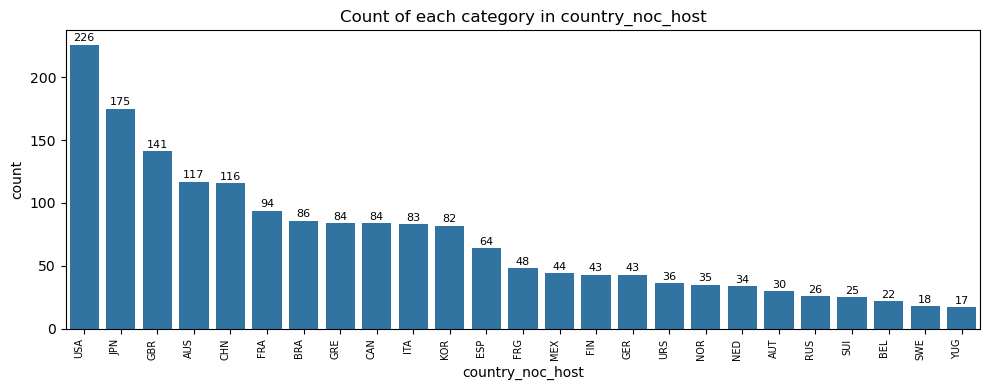

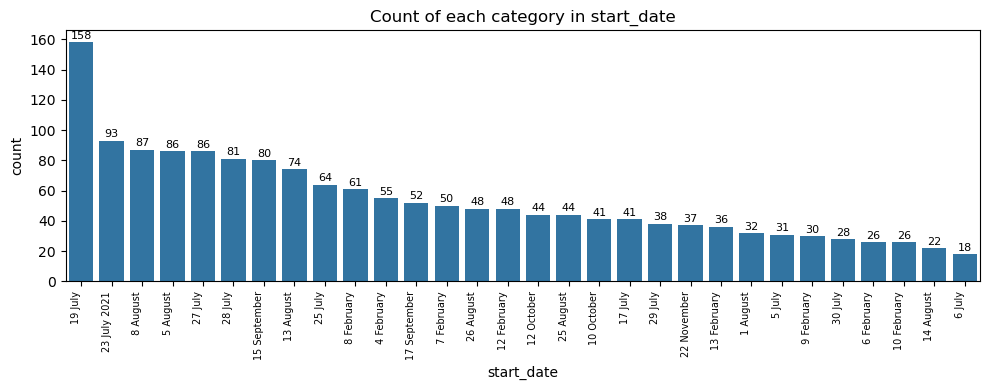

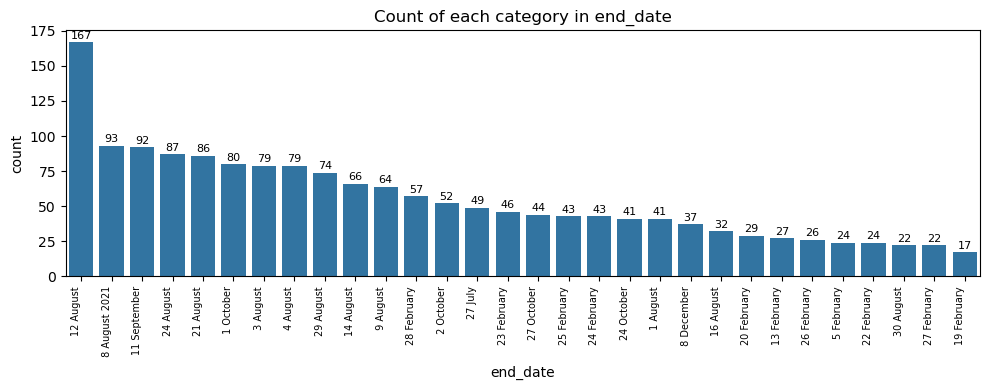

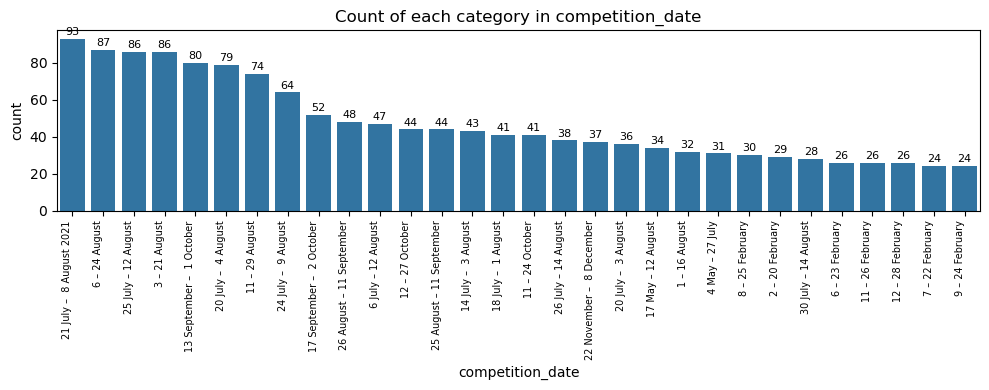

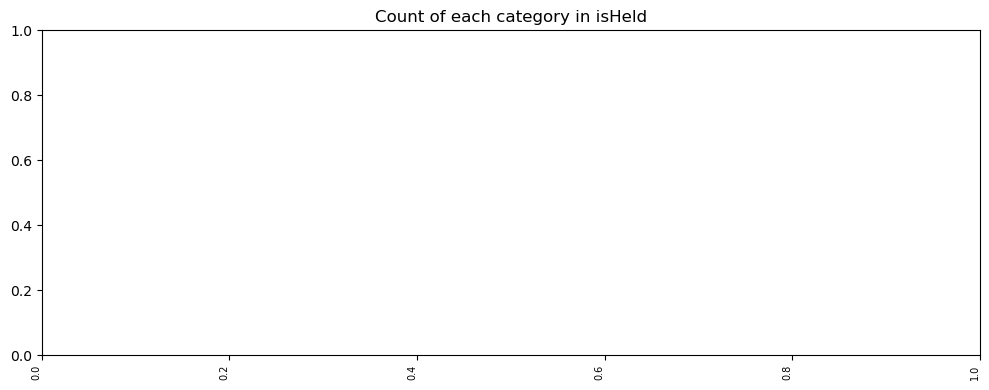

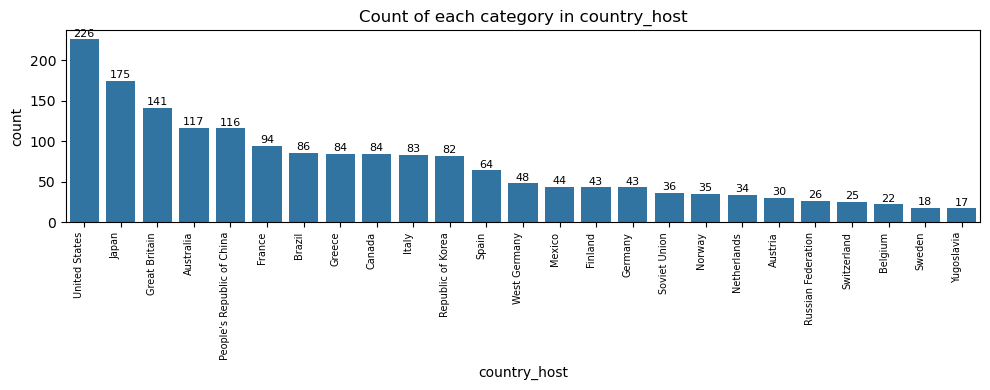

In [126]:
eda_visualization(df)

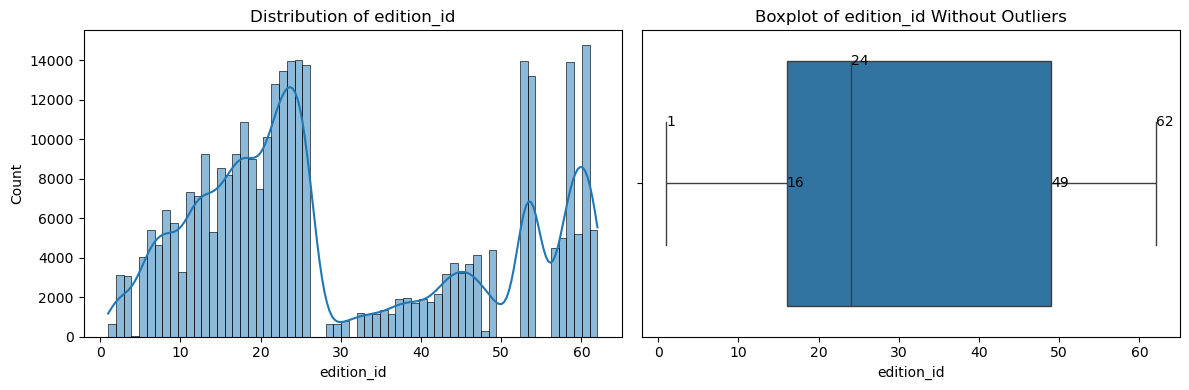

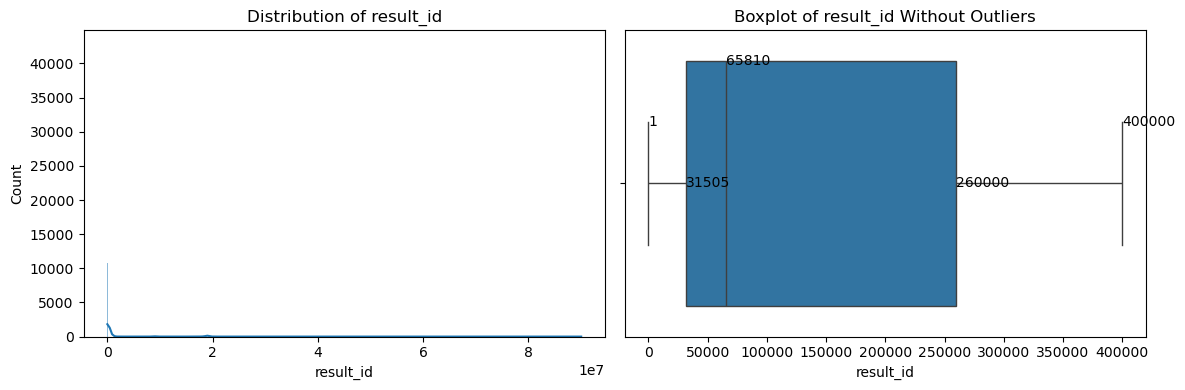

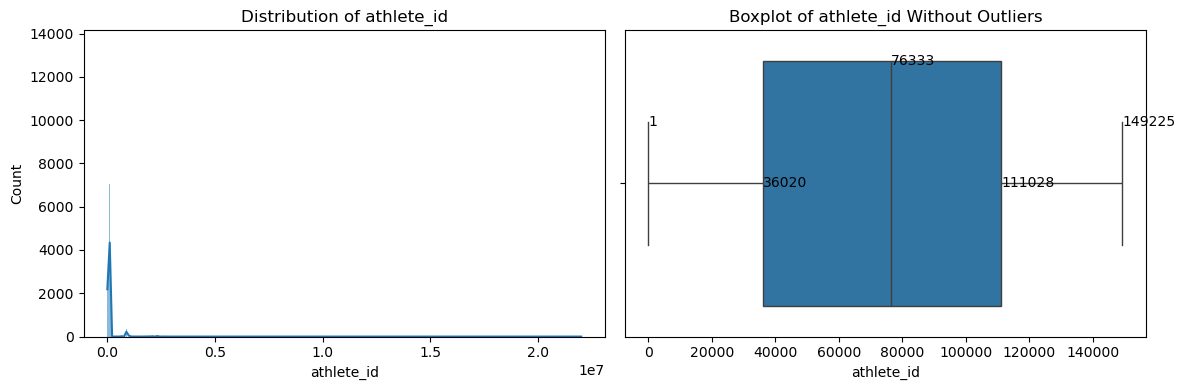

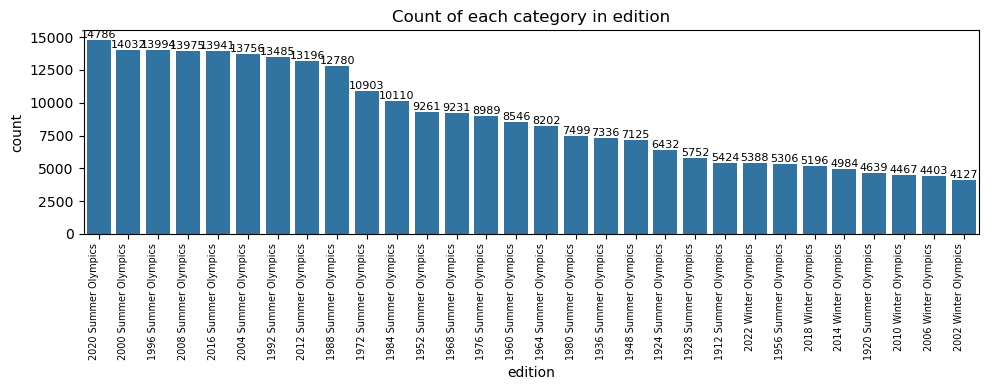

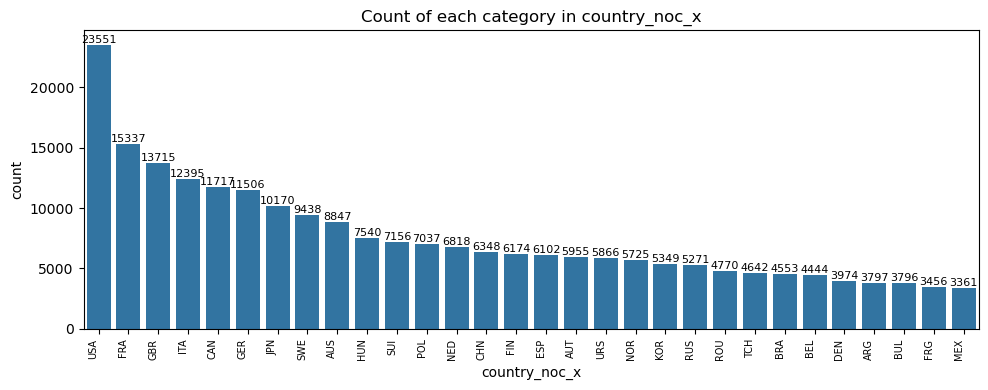

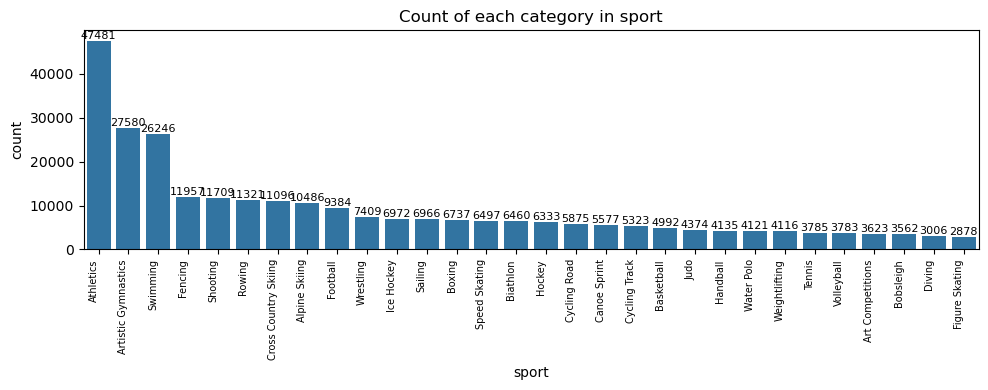

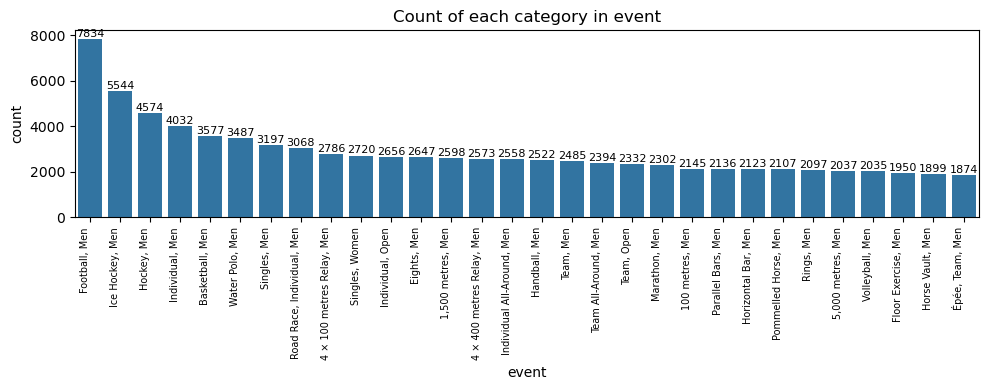

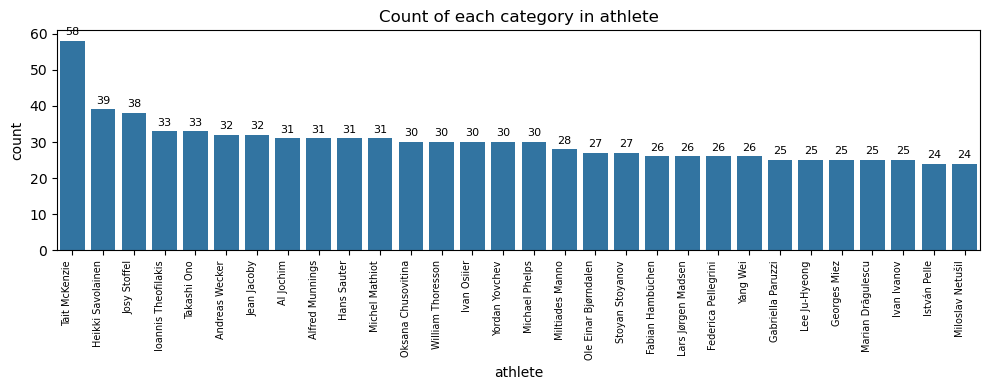

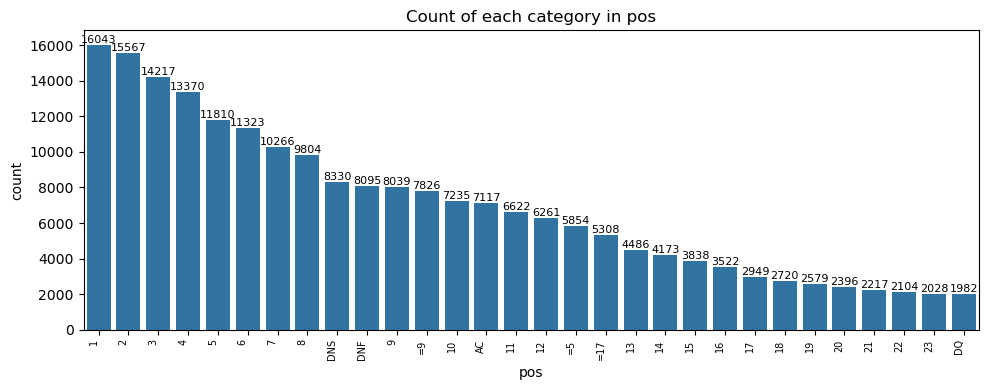

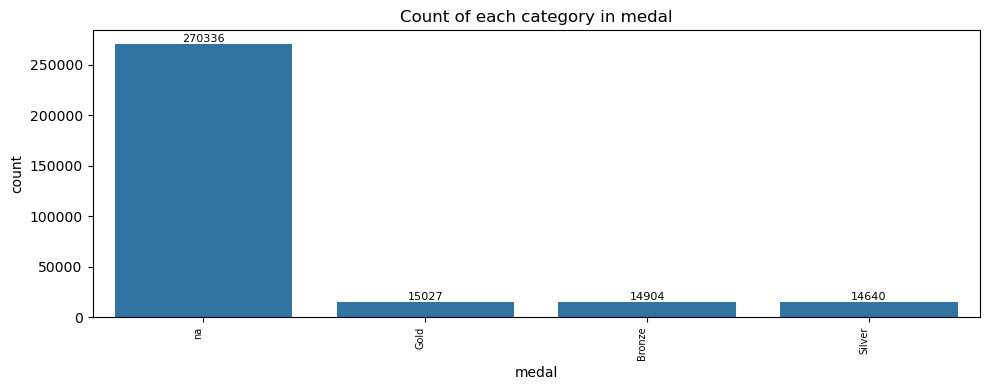

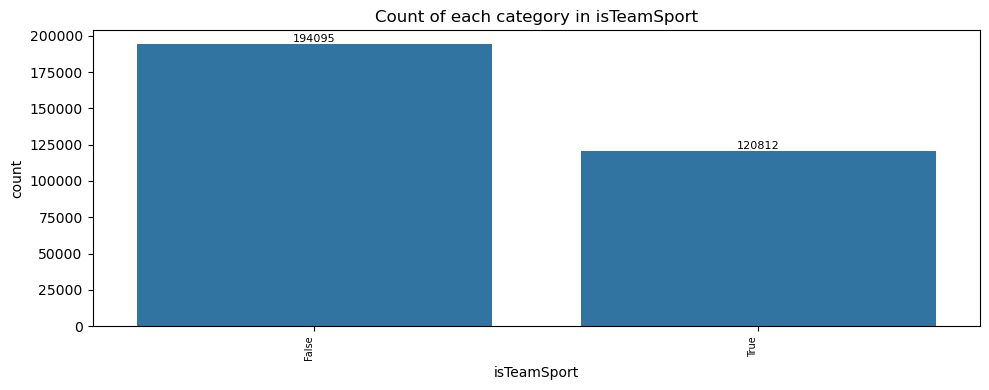

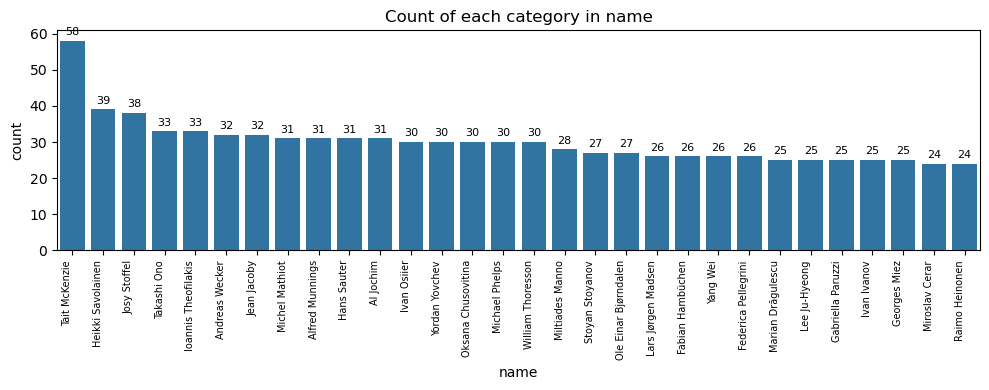

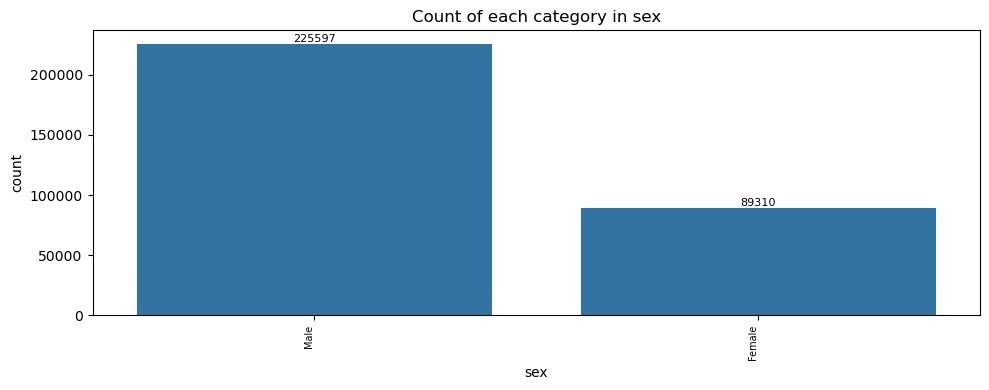

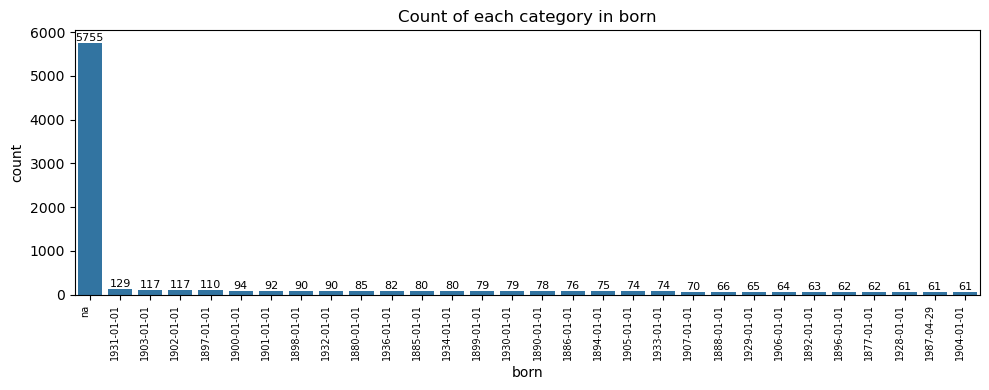

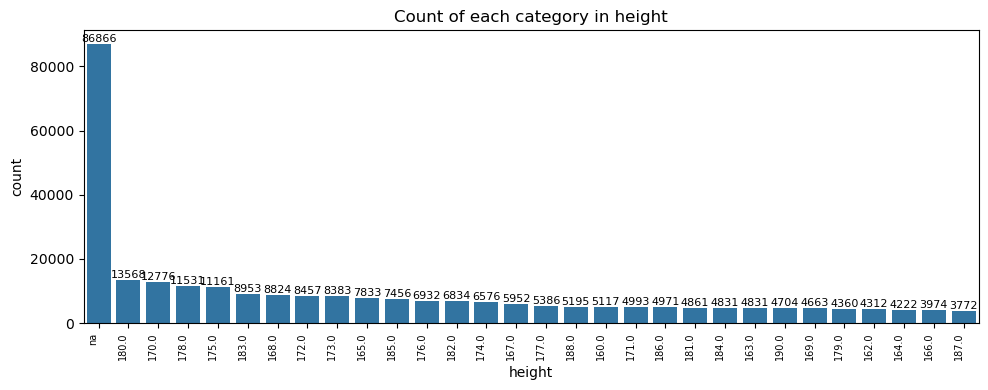

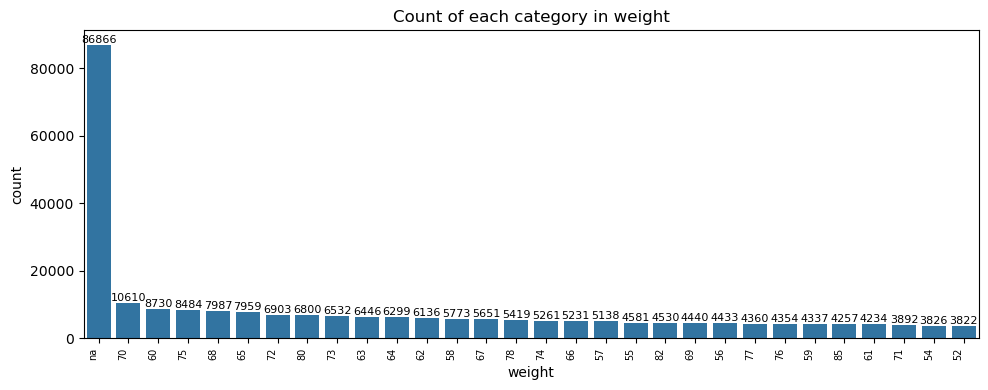

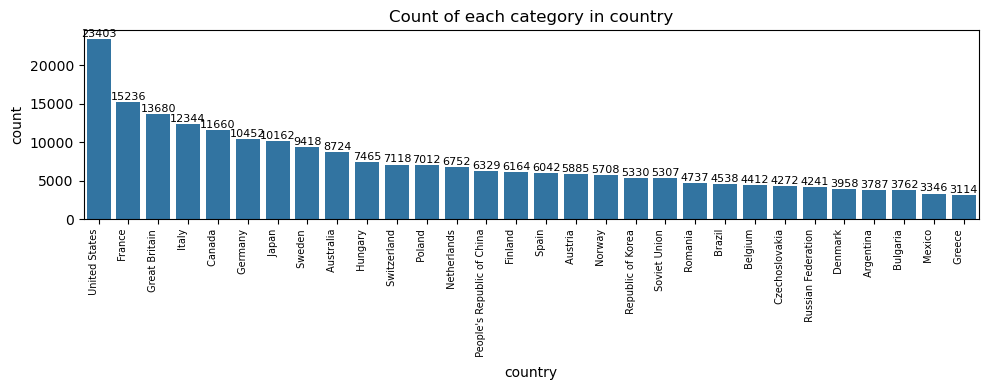

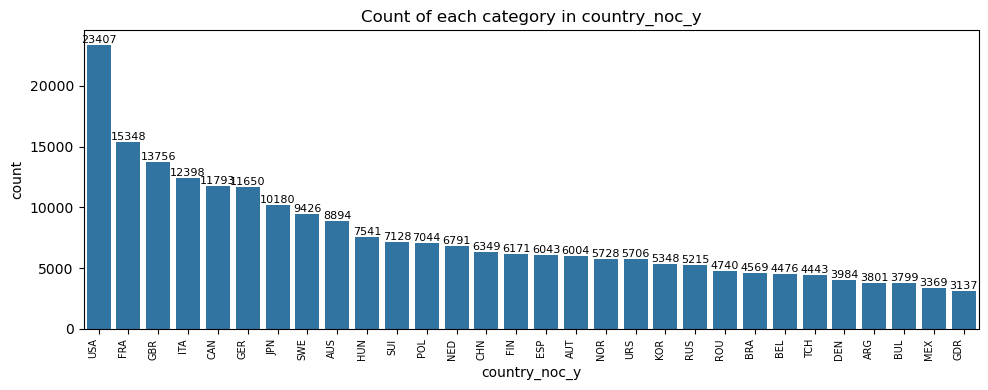

In [125]:
eda_visualization(df_athletes_events[[col for col in df_athletes_events.columns if 'description' not in col and 'special_notes' not in col]])

In [68]:
df_comparison = df.groupby(['country_host', 'edition', 'year', 'country_performing'], as_index=False)['total'].sum() \
    .groupby('edition', group_keys=False) \
    .apply(lambda x: x.nlargest(8,'total'))

In [69]:
df_comparison['season'] = [1 if 'Winter' in edition else 0 for edition in df_comparison['edition']]

In [70]:
# does it look like being host country gives a medal advantage?
fig = px.bar(df_comparison, x='year', y='total',
             hover_data=['country_performing', 'country_host'],
             facet_row='season',
             text=df_comparison.apply(lambda row: row['country_host'] if row['country_host'] == row['country_performing'] else None, axis=1),
             color=df_comparison.apply(lambda row: 'red' if row['country_host'] == row['country_performing'] else 'black', axis=1))
fig.update_layout(showlegend=False, height=750, width=1070)
fig.show()

# these graphs are available at https://sandra-forro.github.io/figures_olymploration/
#pio.write_html(fig, file='graphs/index.html', auto_open=True)